# 02 — Model sweep (classification)

Goal: quickly compare multiple models on the same real-world dataset, then deep-dive with Cleanlab using the best-performing model.

In [1]:
from pathlib import Path
import sys

cwd = Path.cwd()
if (cwd / "src").exists():
    sys.path.insert(0, str(cwd / "src"))
elif (cwd.parent / "src").exists():
    sys.path.insert(0, str(cwd.parent / "src"))


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleanlab_demo.config import CleanlabConfig, DatasetName, DemoConfig, ModelName, RunConfig
from cleanlab_demo.experiments import run_experiment, run_sweep

sns.set_theme(style="whitegrid")


## 1) Quick sweep

We disable Cleanlab here for speed and focus on raw model performance.

In [3]:
base = RunConfig(
    dataset=DatasetName.adult_income,
    cleanlab=CleanlabConfig(enabled=False),
    demo=DemoConfig(max_rows=12000),
)

models = [
    ModelName.logistic_regression,
    ModelName.hist_gradient_boosting,
    ModelName.random_forest,
    ModelName.extra_trees,
    ModelName.knn,
]

rows = run_sweep(dataset=DatasetName.adult_income, models=models, base_config=base)
sweep_df = pd.DataFrame([r.model_dump() for r in rows]).sort_values("primary_metric", ascending=False)
sweep_df


2026-02-08 02:33:08 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:09 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
2026-02-08 02:33:09 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:09 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
2026-02-08 02:33:10 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:10 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
2026-02-08 02:33:14 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:14 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
2026-02-08 02:33:21 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:21 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows


,dataset,task,model,primary_metric,metrics,n_label_issues
1,DatasetName.adult_income,TaskType.classification,ModelName.hist_gradient_boosting,0.920194,"{'accuracy': 0.8695833333333334, 'f1_weighted'...",0
0,DatasetName.adult_income,TaskType.classification,ModelName.logistic_regression,0.900932,"{'accuracy': 0.8504166666666667, 'f1_weighted'...",0
2,DatasetName.adult_income,TaskType.classification,ModelName.random_forest,0.899104,"{'accuracy': 0.8483333333333334, 'f1_weighted'...",0
4,DatasetName.adult_income,TaskType.classification,ModelName.knn,0.881999,"{'accuracy': 0.84625, 'f1_weighted': 0.8427693...",0
3,DatasetName.adult_income,TaskType.classification,ModelName.extra_trees,0.874914,"{'accuracy': 0.8308333333333333, 'f1_weighted'...",0


/var/folders/yx/bj874jc95xv11n436rkbq2140000gp/T/ipykernel_14140/3418634170.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


<Axes: title={'center': 'Primary metric by model'}, xlabel='model', ylabel='primary_metric'>

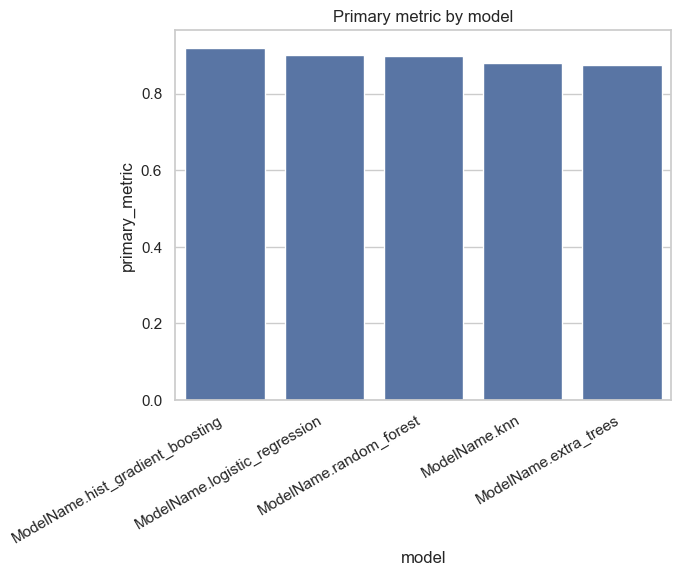

In [4]:
ax = sns.barplot(data=sweep_df, x="model", y="primary_metric")
ax.set_title("Primary metric by model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax


## 2) Deep-dive with Cleanlab

Pick the best model from the sweep and run a Cleanlab-enabled experiment (label issues + Datalab + prune & retrain).

In [5]:
best_model = sweep_df.iloc[0]["model"]
best_model


<ModelName.hist_gradient_boosting: 'hist_gradient_boosting'>

In [6]:
cfg = RunConfig(
    dataset=DatasetName.adult_income,
    model={"name": best_model},
    demo=DemoConfig(max_rows=12000, label_noise_fraction=0.05),
    cleanlab=CleanlabConfig(
        enabled=True,
        use_datalab=True,
        datalab_fast=True,
        prune_and_retrain=True,
        prune_fraction=0.02,
        cv_folds=3,
    ),
)

result = run_experiment(cfg)
pd.DataFrame([{**{"variant": v.variant.value, "primary": v.metrics.primary}, **(v.metrics.details or {})} for v in result.variants])


2026-02-08 02:33:22 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:33:22 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
/Users/rezami/PycharmProjects/Cleanlab_demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,variant,primary,accuracy,f1_weighted,roc_auc
0,baseline,0.909842,0.866250,0.861294,0.909842
1,pruned_retrain,0.914722,0.869167,0.864578,0.914722


In [7]:
pd.DataFrame(result.cleanlab_summary.get("datalab_issue_summary", []))


,issue_type,score,num_issues
0,label,0.908229,1178
1,outlier,0.414294,79
2,near_duplicate,0.563855,1528
3,non_iid,0.881378,0
